<a href="https://colab.research.google.com/github/OTN-Rajapaksha/Naval-Hybrid-Model-Work-In-The-Stock-Market-And-Crypto-Market-Prediction/blob/main/Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ====== REALISTIC BTC DATA (with some noise) ======
# Your actual predictions from your models (replace with real predictions)
your_ann_predictions = [44850, 45320, 44780, 45950, 45180]  # ANN predictions with some error
your_svm_predictions = [45120, 45430, 44910, 45820, 45340]  # SVM predictions with some error
your_actual_values = [45050, 45450, 44850, 45900, 45250]    # Actual BTC prices
# ==========================================================

def create_hybrid_model(ann_predictions, svm_predictions, actual_values, ann_weight=0.1, svm_weight=0.9):
    hybrid_predictions = (ann_weight * np.array(ann_predictions) +
                         svm_weight * np.array(svm_predictions))

    r2 = r2_score(actual_values, hybrid_predictions)
    mse = mean_squared_error(actual_values, hybrid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, hybrid_predictions)
    mape = np.mean(np.abs((np.array(actual_values) - hybrid_predictions) / np.array(actual_values))) * 100

    return hybrid_predictions, r2, mse, rmse, mae, mape

def stacking_hybrid(ann_pred, svm_pred, actual):
    X_stack = np.column_stack([ann_pred, svm_pred])
    meta_model = LinearRegression()
    meta_model.fit(X_stack, actual)
    stacked_predictions = meta_model.predict(X_stack)

    r2 = r2_score(actual, stacked_predictions)
    mse = mean_squared_error(actual, stacked_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, stacked_predictions)
    mape = np.mean(np.abs((np.array(actual) - stacked_predictions) / np.array(actual))) * 100

    return stacked_predictions, meta_model.coef_, r2, mse, rmse, mae, mape

def optimize_hybrid_weights(ann_predictions, svm_predictions, actual_values):
    best_r2 = -float('inf')
    best_weights = (0.1, 0.9)

    print("🔍 Testing different weight combinations for BTC:")
    print("ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE")
    print("-" * 70)

    for ann_w in np.arange(0.0, 1.1, 0.1):
        ann_w = round(ann_w, 1)
        svm_w = round(1 - ann_w, 1)

        hybrid_pred = ann_w * np.array(ann_predictions) + svm_w * np.array(svm_predictions)
        current_r2 = r2_score(actual_values, hybrid_pred)
        current_rmse = np.sqrt(mean_squared_error(actual_values, hybrid_pred))
        current_mae = mean_absolute_error(actual_values, hybrid_pred)
        current_mape = np.mean(np.abs((np.array(actual_values) - hybrid_pred) / np.array(actual_values))) * 100

        print(f"    {ann_w:.1f}    |    {svm_w:.1f}    |  {current_r2:.4f}  | {current_rmse:.2f} | {current_mae:.2f} | {current_mape:.2f}%")

        if current_r2 > best_r2:
            best_r2 = current_r2
            best_weights = (ann_w, svm_w)

    return best_weights, best_r2

# Display original model performance
print("🏆 ORIGINAL MODEL PERFORMANCE - BTC")
print("=" * 85)
print("Model         | R2 Score |      MSE      |   RMSE    |    MAE    | Time(s)")
print("-" * 85)
print(f"SVM           |  0.9928  |  2,764,687   |  1,662.73 |  1,136.91 |  2.140")
print(f"ANN           |  0.9907  |  3,551,175   |  1,884.46 |  1,380.40 | 26.241")
print(f"Decision_Tree |  0.7016  | 114,044,912  | 10,679.18 |  5,275.37 |  0.074")
print(f"Random_Forest |  0.6897  | 118,617,054  | 10,891.15 |  5,043.27 |  6.688")
print(f"LSTM          |  0.5662  | 148,311,274  | 12,178.31 |  8,379.57 | 83.765")

# 1. Find optimal weights
print("\n" + "=" * 85)
optimal_weights, best_r2 = optimize_hybrid_weights(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

print(f"\n✅ OPTIMAL WEIGHTS: ANN={optimal_weights[0]:.2f}, SVM={optimal_weights[1]:.2f}")

# 2. Create simple hybrid
print(f"\n🚀 CREATING SIMPLE HYBRID MODEL...")
simple_hybrid_predictions, r2_simple, mse_simple, rmse_simple, mae_simple, mape_simple = create_hybrid_model(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values,
    optimal_weights[0],
    optimal_weights[1]
)

# 3. Create stacking hybrid
print(f"\n🧠 CREATING STACKING HYBRID MODEL...")
stacked_predictions, stacking_coefficients, r2_stack, mse_stack, rmse_stack, mae_stack, mape_stack = stacking_hybrid(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

# 4. Display results
print(f"\n📊 HYBRID MODEL RESULTS:")
print("Method          | R2 Score |     MSE     |   RMSE    |    MAE    |  MAPE%  | Improv")
print("-" * 90)
print(f"SVM (Baseline)  |  0.9928  | 2,764,687  |  1,662.73 |  1,136.91 |   -     |   -")
print(f"Simple Hybrid   |  {r2_simple:.4f}  | {mse_simple:9.0f} | {rmse_simple:7.0f}   | {mae_simple:7.0f}  | {mape_simple:5.2f}%  | {r2_simple - 0.9928:+.4f}")
print(f"Stacking Hybrid |  {r2_stack:.4f}  | {mse_stack:9.0f} | {rmse_stack:7.0f}   | {mae_stack:7.0f}  | {mape_stack:5.2f}%  | {r2_stack - 0.9928:+.4f}")

print(f"\n🔧 Stacking Coefficients: ANN={stacking_coefficients[0]:.4f}, SVM={stacking_coefficients[1]:.4f}")

# 5. Determine best approach
best_r2 = max(r2_simple, r2_stack, 0.9928)
if best_r2 == r2_simple:
    best_method = "Simple Hybrid"
    best_predictions = simple_hybrid_predictions
elif best_r2 == r2_stack:
    best_method = "Stacking Hybrid"
    best_predictions = stacked_predictions
else:
    best_method = "SVM Alone"
    best_predictions = your_svm_predictions

print(f"\n🎯 BEST APPROACH: {best_method}")
print(f"   Best R2 Score: {best_r2:.4f}")

if best_r2 > 0.9928:
    improvement_pct = ((best_r2 - 0.9928) / 0.9928) * 100
    print(f"   🎉 OUTPERFORMS SVM! (+{improvement_pct:.2f}%)")
else:
    print(f"   ✅ SVM is best performer")

# 6. Show predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Index |  Actual   |   ANN     |   SVM     |  Best Pred |  Error")
print("-" * 75)
for i in range(len(your_actual_values)):
    error = your_actual_values[i] - best_predictions[i]
    print(f"{i+1:5d} | {your_actual_values[i]:9.0f} | {your_ann_predictions[i]:9.0f} | {your_svm_predictions[i]:9.0f} | {best_predictions[i]:9.0f} | {error:8.0f}")

# 7. Final summary
print(f"\n📋 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_method}")
print(f"   Best R2: {best_r2:.4f}")
print(f"   SVM R2: 0.9928")
print(f"   ANN R2: 0.9907")
print(f"   Gap: {best_r2 - 0.9928:+.4f}")

# 8. Recommendation with explanation
print(f"\n💡 RECOMMENDATION:")
if best_method == "SVM Alone":
    print("   Use SVM model alone - it provides the best individual performance")
elif best_method == "Simple Hybrid":
    print("   Use Simple Hybrid - weighted average provides better performance")
    print("   Stacking not recommended: Small dataset causes overfitting")
else:
    print("   Use Stacking Hybrid - meta-learning provides optimal combination")
    print("   Simple Hybrid also good: Close performance with less complexity")



🏆 ORIGINAL MODEL PERFORMANCE - BTC
Model         | R2 Score |      MSE      |   RMSE    |    MAE    | Time(s)
-------------------------------------------------------------------------------------
SVM           |  0.9928  |  2,764,687   |  1,662.73 |  1,136.91 |  2.140
ANN           |  0.9907  |  3,551,175   |  1,884.46 |  1,380.40 | 26.241
Decision_Tree |  0.7016  | 114,044,912  | 10,679.18 |  5,275.37 |  0.074
Random_Forest |  0.6897  | 118,617,054  | 10,891.15 |  5,043.27 |  6.688
LSTM          |  0.5662  | 148,311,274  | 12,178.31 |  8,379.57 | 83.765

🔍 Testing different weight combinations for BTC:
ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE
----------------------------------------------------------------------
    0.0    |    1.0    |  0.9640  | 68.41 | 64.00 | 0.14%
    0.1    |    0.9    |  0.9769  | 54.74 | 52.40 | 0.12%
    0.2    |    0.8    |  0.9855  | 43.49 | 40.80 | 0.09%
    0.3    |    0.7    |  0.9895  | 36.92 | 33.60 | 0.07%
    0.4    |    0.6  

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ====== REPLACE THESE WITH YOUR ACTUAL CRUDE OIL DATA ======
your_ann_predictions = [75.5, 76.2, 74.8, 77.1, 75.9]
your_svm_predictions = [75.8, 76.0, 75.1, 76.8, 76.2]
your_actual_values = [75.6, 76.1, 75.0, 76.5, 76.0]
# ==========================================================

def create_hybrid_model(ann_predictions, svm_predictions, actual_values, ann_weight=0.1, svm_weight=0.9):
    hybrid_predictions = (ann_weight * np.array(ann_predictions) +
                         svm_weight * np.array(svm_predictions))

    r2 = r2_score(actual_values, hybrid_predictions)
    mse = mean_squared_error(actual_values, hybrid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, hybrid_predictions)
    mape = np.mean(np.abs((np.array(actual_values) - hybrid_predictions) / np.array(actual_values))) * 100

    return hybrid_predictions, r2, mse, rmse, mae, mape

def stacking_hybrid(ann_pred, svm_pred, actual):
    X_stack = np.column_stack([ann_pred, svm_pred])
    meta_model = LinearRegression()
    meta_model.fit(X_stack, actual)
    stacked_predictions = meta_model.predict(X_stack)

    r2 = r2_score(actual, stacked_predictions)
    mse = mean_squared_error(actual, stacked_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, stacked_predictions)
    mape = np.mean(np.abs((np.array(actual) - stacked_predictions) / np.array(actual))) * 100

    return stacked_predictions, meta_model.coef_, r2, mse, rmse, mae, mape

def optimize_hybrid_weights(ann_predictions, svm_predictions, actual_values):
    best_r2 = -float('inf')
    best_weights = (0.1, 0.9)

    print("🔍 Testing different weight combinations for Crude Oil:")
    print("ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE")
    print("-" * 70)

    for ann_w in np.arange(0.0, 1.1, 0.1):
        ann_w = round(ann_w, 1)
        svm_w = round(1 - ann_w, 1)

        hybrid_pred = ann_w * np.array(ann_predictions) + svm_w * np.array(svm_predictions)
        current_r2 = r2_score(actual_values, hybrid_pred)
        current_rmse = np.sqrt(mean_squared_error(actual_values, hybrid_pred))
        current_mae = mean_absolute_error(actual_values, hybrid_pred)
        current_mape = np.mean(np.abs((np.array(actual_values) - hybrid_pred) / np.array(actual_values))) * 100

        print(f"    {ann_w:.1f}    |    {svm_w:.1f}    |  {current_r2:.4f}  | {current_rmse:.4f} | {current_mae:.4f} | {current_mape:.2f}%")

        if current_r2 > best_r2:
            best_r2 = current_r2
            best_weights = (ann_w, svm_w)

    return best_weights, best_r2

# Display original model performance
print("🏆 ORIGINAL MODEL PERFORMANCE - CRUDE OIL")
print("=" * 80)
print("Model         | R2 Score |   MSE    |   RMSE   |   MAE   | Time(s)")
print("-" * 80)
print(f"SVM           |  0.9420  |  2.1433  |  1.4640  |  1.1585  |  1.413")
print(f"Random_Forest |  0.9294  |  2.6072  |  1.6147  |  1.2855  |  1.935")
print(f"ANN           |  0.9233  |  2.8353  |  1.6838  |  1.3276  | 25.903")
print(f"Decision_Tree |  0.9140  |  3.1779  |  1.7827  |  1.4482  |  0.014")
print(f"LSTM          |  0.6041  | 14.8070  |  3.8480  |  3.1935  | 69.479")

# 1. Find optimal weights
print("\n" + "=" * 80)
optimal_weights, best_r2 = optimize_hybrid_weights(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

print(f"\n✅ OPTIMAL WEIGHTS: ANN={optimal_weights[0]:.2f}, SVM={optimal_weights[1]:.2f}")

# 2. Create simple hybrid
print(f"\n🚀 CREATING SIMPLE HYBRID MODEL...")
simple_hybrid_predictions, r2_simple, mse_simple, rmse_simple, mae_simple, mape_simple = create_hybrid_model(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values,
    optimal_weights[0],
    optimal_weights[1]
)

# 3. Create stacking hybrid
print(f"\n🧠 CREATING STACKING HYBRID MODEL...")
stacked_predictions, stacking_coefficients, r2_stack, mse_stack, rmse_stack, mae_stack, mape_stack = stacking_hybrid(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

# 4. Display results
print(f"\n📊 HYBRID MODEL RESULTS:")
print("Method          | R2 Score |   MSE    |   RMSE   |   MAE   |  MAPE%  | Improv")
print("-" * 85)
print(f"SVM (Baseline)  |  0.9420  |  2.1433  |  1.4640  |  1.1585  |   -     |   -")
print(f"Simple Hybrid   |  {r2_simple:.4f}  | {mse_simple:6.4f}  | {rmse_simple:6.4f}  | {mae_simple:6.4f}  | {mape_simple:5.2f}%  | {r2_simple - 0.9420:+.4f}")
print(f"Stacking Hybrid |  {r2_stack:.4f}  | {mse_stack:6.4f}  | {rmse_stack:6.4f}  | {mae_stack:6.4f}  | {mape_stack:5.2f}%  | {r2_stack - 0.9420:+.4f}")

print(f"\n🔧 Stacking Coefficients: ANN={stacking_coefficients[0]:.4f}, SVM={stacking_coefficients[1]:.4f}")

# 5. Determine best approach
best_r2 = max(r2_simple, r2_stack, 0.9420)
if best_r2 == r2_simple:
    best_method = "Simple Hybrid"
    best_predictions = simple_hybrid_predictions
elif best_r2 == r2_stack:
    best_method = "Stacking Hybrid"
    best_predictions = stacked_predictions
else:
    best_method = "SVM Alone"
    best_predictions = your_svm_predictions

print(f"\n🎯 BEST APPROACH: {best_method}")
print(f"   Best R2 Score: {best_r2:.4f}")

if best_r2 > 0.9420:
    improvement_pct = ((best_r2 - 0.9420) / 0.9420) * 100
    print(f"   🎉 OUTPERFORMS SVM! (+{improvement_pct:.2f}%)")
else:
    print(f"   ✅ SVM is best performer")

# 6. Show predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Index |  Actual  |   ANN    |   SVM    |  Best Pred |  Error")
print("-" * 70)
for i in range(len(your_actual_values)):
    error = your_actual_values[i] - best_predictions[i]
    print(f"{i+1:5d} | {your_actual_values[i]:8.2f} | {your_ann_predictions[i]:8.2f} | {your_svm_predictions[i]:8.2f} | {best_predictions[i]:8.2f} | {error:8.2f}")

# 7. Final summary
print(f"\n📋 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_method}")
print(f"   Best R2: {best_r2:.4f}")
print(f"   SVM R2: 0.9420")
print(f"   ANN R2: 0.9233")
print(f"   Gap: {best_r2 - 0.9420:+.4f}")

# 8. Recommendation
print(f"\n💡 RECOMMENDATION:")
if best_method == "SVM Alone":
    print("   Use SVM model alone")
else:
    print(f"   Use {best_method}")

🏆 ORIGINAL MODEL PERFORMANCE - CRUDE OIL
Model         | R2 Score |   MSE    |   RMSE   |   MAE   | Time(s)
--------------------------------------------------------------------------------
SVM           |  0.9420  |  2.1433  |  1.4640  |  1.1585  |  1.413
Random_Forest |  0.9294  |  2.6072  |  1.6147  |  1.2855  |  1.935
ANN           |  0.9233  |  2.8353  |  1.6838  |  1.3276  | 25.903
Decision_Tree |  0.9140  |  3.1779  |  1.7827  |  1.4482  |  0.014
LSTM          |  0.6041  | 14.8070  |  3.8480  |  3.1935  | 69.479

🔍 Testing different weight combinations for Crude Oil:
ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE
----------------------------------------------------------------------
    0.0    |    1.0    |  0.8529  | 0.1949 | 0.1800 | 0.24%
    0.1    |    0.9    |  0.8622  | 0.1887 | 0.1640 | 0.22%
    0.2    |    0.8    |  0.8653  | 0.1865 | 0.1480 | 0.19%
    0.3    |    0.7    |  0.8622  | 0.1887 | 0.1320 | 0.17%
    0.4    |    0.6    |  0.8529  | 0.1949 |

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ====== REPLACE THESE WITH YOUR ACTUAL NYSE STOCK DATA ======
your_ann_predictions = [2850, 2900, 2820, 2950, 2880]
your_svm_predictions = [2860, 2895, 2830, 2940, 2890]
your_actual_values = [2855, 2898, 2825, 2945, 2885]
# ==========================================================

def create_hybrid_model(ann_predictions, svm_predictions, actual_values, ann_weight=0.1, svm_weight=0.9):
    hybrid_predictions = (ann_weight * np.array(ann_predictions) +
                         svm_weight * np.array(svm_predictions))

    r2 = r2_score(actual_values, hybrid_predictions)
    mse = mean_squared_error(actual_values, hybrid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, hybrid_predictions)
    mape = np.mean(np.abs((np.array(actual_values) - hybrid_predictions) / np.array(actual_values))) * 100

    return hybrid_predictions, r2, mse, rmse, mae, mape

def stacking_hybrid(ann_pred, svm_pred, actual):
    X_stack = np.column_stack([ann_pred, svm_pred])
    meta_model = LinearRegression()
    meta_model.fit(X_stack, actual)
    stacked_predictions = meta_model.predict(X_stack)

    r2 = r2_score(actual, stacked_predictions)
    mse = mean_squared_error(actual, stacked_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, stacked_predictions)
    mape = np.mean(np.abs((np.array(actual) - stacked_predictions) / np.array(actual))) * 100

    return stacked_predictions, meta_model.coef_, r2, mse, rmse, mae, mape

def optimize_hybrid_weights(ann_predictions, svm_predictions, actual_values):
    best_r2 = -float('inf')
    best_weights = (0.1, 0.9)

    print("🔍 Testing different weight combinations for NYSE Stock:")
    print("ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE")
    print("-" * 70)

    for ann_w in np.arange(0.0, 1.1, 0.1):
        ann_w = round(ann_w, 1)
        svm_w = round(1 - ann_w, 1)

        hybrid_pred = ann_w * np.array(ann_predictions) + svm_w * np.array(svm_predictions)
        current_r2 = r2_score(actual_values, hybrid_pred)
        current_rmse = np.sqrt(mean_squared_error(actual_values, hybrid_pred))
        current_mae = mean_absolute_error(actual_values, hybrid_pred)
        current_mape = np.mean(np.abs((np.array(actual_values) - hybrid_pred) / np.array(actual_values))) * 100

        print(f"    {ann_w:.1f}    |    {svm_w:.1f}    |  {current_r2:.4f}  | {current_rmse:.4f} | {current_mae:.4f} | {current_mape:.2f}%")

        if current_r2 > best_r2:
            best_r2 = current_r2
            best_weights = (ann_w, svm_w)

    return best_weights, best_r2

# Display original model performance
print("🏆 ORIGINAL MODEL PERFORMANCE - NYSE STOCK")
print("=" * 85)
print("Model           | R2 Score |      MSE      |   RMSE    |    MAE    | Time(s)")
print("-" * 85)
print(f"SVM             |  0.9927  |  15,678.93   |  125.22   |   97.87   |  0.798")
print(f"ANN             |  0.9723  |  59,725.23   |  244.39   |  194.68   | 32.877")
print(f"LSTM_Optimized  |  0.2505  | 1,595,356.00 | 1,263.07  | 1,010.04  | 71.676")
print(f"Random_Forest   |  0.1803  | 1,765,492.00 | 1,328.72  |  957.82   |  1.543")
print(f"Decision_Tree   |  0.1350  | 1,862,927.00 | 1,364.89  | 1,000.01  |  0.016")

# 1. Find optimal weights
print("\n" + "=" * 85)
optimal_weights, best_r2 = optimize_hybrid_weights(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

print(f"\n✅ OPTIMAL WEIGHTS: ANN={optimal_weights[0]:.2f}, SVM={optimal_weights[1]:.2f}")

# 2. Create simple hybrid
print(f"\n🚀 CREATING SIMPLE HYBRID MODEL...")
simple_hybrid_predictions, r2_simple, mse_simple, rmse_simple, mae_simple, mape_simple = create_hybrid_model(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values,
    optimal_weights[0],
    optimal_weights[1]
)

# 3. Create stacking hybrid
print(f"\n🧠 CREATING STACKING HYBRID MODEL...")
stacked_predictions, stacking_coefficients, r2_stack, mse_stack, rmse_stack, mae_stack, mape_stack = stacking_hybrid(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

# 4. Display results
print(f"\n📊 HYBRID MODEL RESULTS:")
print("Method          | R2 Score |     MSE     |   RMSE    |    MAE    |  MAPE%  | Improv vs SVM")
print("-" * 90)
print(f"SVM (Baseline)  |  0.9927  | 15,678.93  |  125.22   |   97.87   |   -     |      -")
print(f"Simple Hybrid   |  {r2_simple:.4f}  | {mse_simple:9.2f} | {rmse_simple:7.2f}   | {mae_simple:7.2f}  | {mape_simple:5.2f}%  |   {r2_simple - 0.9927:+.4f}")
print(f"Stacking Hybrid |  {r2_stack:.4f}  | {mse_stack:9.2f} | {rmse_stack:7.2f}   | {mae_stack:7.2f}  | {mape_stack:5.2f}%  |   {r2_stack - 0.9927:+.4f}")

print(f"\n🔧 Stacking Coefficients: ANN={stacking_coefficients[0]:.4f}, SVM={stacking_coefficients[1]:.4f}")

# 5. Determine best approach
best_r2 = max(r2_simple, r2_stack, 0.9927)
if best_r2 == r2_simple:
    best_method = "Simple Hybrid"
    best_predictions = simple_hybrid_predictions
elif best_r2 == r2_stack:
    best_method = "Stacking Hybrid"
    best_predictions = stacked_predictions
else:
    best_method = "SVM Alone"
    best_predictions = your_svm_predictions

print(f"\n🎯 BEST APPROACH: {best_method}")
print(f"   Best R2 Score: {best_r2:.4f}")

if best_r2 > 0.9927:
    improvement_pct = ((best_r2 - 0.9927) / 0.9927) * 100
    print(f"   🎉 {best_method} OUTPERFORMS SVM! (+{improvement_pct:.2f}%)")
else:
    print(f"   ✅ SVM Alone is the best performer")

# 6. Show predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Index |  Actual   |   ANN     |   SVM     |  Best Pred |  Error   | Error%")
print("-" * 75)
for i in range(len(your_actual_values)):
    error = your_actual_values[i] - best_predictions[i]
    error_pct = (error / your_actual_values[i]) * 100
    print(f"{i+1:5d} | {your_actual_values[i]:9.2f} | {your_ann_predictions[i]:9.2f} | {your_svm_predictions[i]:9.2f} | {best_predictions[i]:9.2f} | {error:8.2f} | {error_pct:5.1f}%")

# 7. Final summary
print(f"\n📋 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_method}")
print(f"   Best R2: {best_r2:.4f}")
print(f"   SVM R2: 0.9927")
print(f"   ANN R2: 0.9723")
print(f"   Performance Gap: {best_r2 - 0.9927:+.4f}")

# 8. Recommendation
print(f"\n💡 RECOMMENDATION:")
if best_method == "SVM Alone":
    print("   Use SVM model alone - best performance")
else:
    print(f"   Use {best_method} - better than individual models")

🏆 ORIGINAL MODEL PERFORMANCE - NYSE STOCK
Model           | R2 Score |      MSE      |   RMSE    |    MAE    | Time(s)
-------------------------------------------------------------------------------------
SVM             |  0.9927  |  15,678.93   |  125.22   |   97.87   |  0.798
ANN             |  0.9723  |  59,725.23   |  244.39   |  194.68   | 32.877
LSTM_Optimized  |  0.2505  | 1,595,356.00 | 1,263.07  | 1,010.04  | 71.676
Random_Forest   |  0.1803  | 1,765,492.00 | 1,328.72  |  957.82   |  1.543
Decision_Tree   |  0.1350  | 1,862,927.00 | 1,364.89  | 1,000.01  |  0.016

🔍 Testing different weight combinations for NYSE Stock:
ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE
----------------------------------------------------------------------
    0.0    |    1.0    |  0.9867  | 4.6690 | 4.6000 | 0.16%
    0.1    |    0.9    |  0.9914  | 3.7483 | 3.7000 | 0.13%
    0.2    |    0.8    |  0.9951  | 2.8284 | 2.8000 | 0.10%
    0.3    |    0.7    |  0.9978  | 1.9105 | 1.

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ====== REPLACE THESE WITH YOUR ACTUAL JKH STOCK DATA ======
your_ann_predictions = [150.5, 152.2, 148.8, 155.1, 151.9]
your_svm_predictions = [151.2, 151.8, 149.5, 154.3, 152.1]
your_actual_values = [150.8, 152.0, 149.2, 154.7, 152.0]
# ==========================================================

def create_hybrid_model(ann_predictions, svm_predictions, actual_values, ann_weight=0.1, svm_weight=0.9):
    hybrid_predictions = (ann_weight * np.array(ann_predictions) +
                         svm_weight * np.array(svm_predictions))

    r2 = r2_score(actual_values, hybrid_predictions)
    mse = mean_squared_error(actual_values, hybrid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, hybrid_predictions)
    mape = np.mean(np.abs((np.array(actual_values) - hybrid_predictions) / np.array(actual_values))) * 100

    return hybrid_predictions, r2, mse, rmse, mae, mape

def stacking_hybrid(ann_pred, svm_pred, actual):
    X_stack = np.column_stack([ann_pred, svm_pred])
    meta_model = LinearRegression()
    meta_model.fit(X_stack, actual)
    stacked_predictions = meta_model.predict(X_stack)

    r2 = r2_score(actual, stacked_predictions)
    mse = mean_squared_error(actual, stacked_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, stacked_predictions)
    mape = np.mean(np.abs((np.array(actual) - stacked_predictions) / np.array(actual))) * 100

    return stacked_predictions, meta_model.coef_, r2, mse, rmse, mae, mape

def optimize_hybrid_weights(ann_predictions, svm_predictions, actual_values):
    best_r2 = -float('inf')
    best_weights = (0.1, 0.9)

    print("🔍 Testing different weight combinations:")
    print("ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE")
    print("-" * 70)

    for ann_w in np.arange(0.0, 1.1, 0.1):
        ann_w = round(ann_w, 1)
        svm_w = round(1 - ann_w, 1)

        hybrid_pred = ann_w * np.array(ann_predictions) + svm_w * np.array(svm_predictions)
        current_r2 = r2_score(actual_values, hybrid_pred)
        current_rmse = np.sqrt(mean_squared_error(actual_values, hybrid_pred))
        current_mae = mean_absolute_error(actual_values, hybrid_pred)
        current_mape = np.mean(np.abs((np.array(actual_values) - hybrid_pred) / np.array(actual_values))) * 100

        print(f"    {ann_w:.1f}    |    {svm_w:.1f}    |  {current_r2:.4f}  | {current_rmse:.4f} | {current_mae:.4f} | {current_mape:.2f}%")

        if current_r2 > best_r2:
            best_r2 = current_r2
            best_weights = (ann_w, svm_w)

    return best_weights, best_r2

# Display original model performance
print("🏆 ORIGINAL MODEL PERFORMANCE - JKH STOCK")
print("=" * 80)
print("Model         | R2 Score |   MSE    |   RMSE   |   MAE   |  MAPE%  | Time(s)")
print("-" * 80)
print(f"SVM           |  0.9605  | 123.80  |  11.13   |  3.13   |  8.85%  |  9.922")
print(f"ANN           |  0.9100  | 282.24  |  16.80   |  8.93   | 23.35%  | 10.221")
print(f"Decision Tree |  0.7784  | 695.30  |  26.37   | 14.72   | 43.63%  |  0.058")
print(f"Random Forest |  0.7370  | 825.23  |  28.73   | 15.24   | 47.83%  |  5.864")

# 1. Find optimal weights
print("\n" + "=" * 85)
optimal_weights, best_r2 = optimize_hybrid_weights(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

print(f"\n✅ OPTIMAL WEIGHTS: ANN={optimal_weights[0]:.2f}, SVM={optimal_weights[1]:.2f}")

# 2. Create simple hybrid
print(f"\n🚀 CREATING SIMPLE HYBRID MODEL...")
simple_hybrid_predictions, r2_simple, mse_simple, rmse_simple, mae_simple, mape_simple = create_hybrid_model(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values,
    optimal_weights[0],
    optimal_weights[1]
)

# 3. Create stacking hybrid
print(f"\n🧠 CREATING STACKING HYBRID MODEL...")
stacked_predictions, stacking_coefficients, r2_stack, mse_stack, rmse_stack, mae_stack, mape_stack = stacking_hybrid(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

# 4. Display results
print(f"\n📊 HYBRID MODEL RESULTS:")
print("Method          | R2 Score |   MSE    |   RMSE   |   MAE   |  MAPE%  | Improv vs SVM")
print("-" * 85)
print(f"SVM (Baseline)  |  0.9605  | 123.80  |  11.13   |  3.13   |  8.85%  |      -")
print(f"Simple Hybrid   |  {r2_simple:.4f}  | {mse_simple:6.2f}  | {rmse_simple:6.2f}   | {mae_simple:5.2f}   | {mape_simple:5.2f}%  |   {r2_simple - 0.9605:+.4f}")
print(f"Stacking Hybrid |  {r2_stack:.4f}  | {mse_stack:6.2f}  | {rmse_stack:6.2f}   | {mae_stack:5.2f}   | {mape_stack:5.2f}%  |   {r2_stack - 0.9605:+.4f}")

print(f"\n🔧 Stacking Coefficients: ANN={stacking_coefficients[0]:.4f}, SVM={stacking_coefficients[1]:.4f}")

# 5. Determine best approach
best_r2 = max(r2_simple, r2_stack, 0.9605)
if best_r2 == r2_simple:
    best_method = "Simple Hybrid"
    best_predictions = simple_hybrid_predictions
elif best_r2 == r2_stack:
    best_method = "Stacking Hybrid"
    best_predictions = stacked_predictions
else:
    best_method = "SVM Alone"
    best_predictions = your_svm_predictions

print(f"\n🎯 BEST APPROACH: {best_method}")
print(f"   Best R2 Score: {best_r2:.4f}")

if best_r2 > 0.9605:
    improvement_pct = ((best_r2 - 0.9605) / 0.9605) * 100
    print(f"   🎉 {best_method} OUTPERFORMS SVM! (+{improvement_pct:.2f}%)")
else:
    print(f"   ✅ SVM Alone is the best performer")

# 6. Show predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Index |  Actual  |   ANN    |   SVM    |  Best Pred |  Error  | Error%")
print("-" * 70)
for i in range(len(your_actual_values)):
    error = your_actual_values[i] - best_predictions[i]
    error_pct = (error / your_actual_values[i]) * 100
    print(f"{i+1:5d} | {your_actual_values[i]:8.2f} | {your_ann_predictions[i]:8.2f} | {your_svm_predictions[i]:8.2f} | {best_predictions[i]:8.2f} | {error:7.2f} | {error_pct:5.1f}%")

# 7. Final summary
print(f"\n📋 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_method}")
print(f"   Best R2: {best_r2:.4f}")
print(f"   SVM R2: 0.9605")
print(f"   ANN R2: 0.9100")
print(f"   Performance Gap: {best_r2 - 0.9605:+.4f}")

# 8. Recommendation
print(f"\n💡 RECOMMENDATION:")
if best_method == "SVM Alone":
    print("   Use SVM model alone - best performance")
else:
    print(f"   Use {best_method} - better than individual models")

🏆 ORIGINAL MODEL PERFORMANCE - JKH STOCK
Model         | R2 Score |   MSE    |   RMSE   |   MAE   |  MAPE%  | Time(s)
--------------------------------------------------------------------------------
SVM           |  0.9605  | 123.80  |  11.13   |  3.13   |  8.85%  |  9.922
ANN           |  0.9100  | 282.24  |  16.80   |  8.93   | 23.35%  | 10.221
Decision Tree |  0.7784  | 695.30  |  26.37   | 14.72   | 43.63%  |  0.058
Random Forest |  0.7370  | 825.23  |  28.73   | 15.24   | 47.83%  |  5.864

🔍 Testing different weight combinations:
ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE
----------------------------------------------------------------------
    0.0    |    1.0    |  0.9717  | 0.3033 | 0.2800 | 0.18%
    0.1    |    0.9    |  0.9818  | 0.2434 | 0.2240 | 0.15%
    0.2    |    0.8    |  0.9896  | 0.1837 | 0.1680 | 0.11%
    0.3    |    0.7    |  0.9952  | 0.1247 | 0.1120 | 0.07%
    0.4    |    0.6    |  0.9986  | 0.0681 | 0.0560 | 0.04%
    0.5    |    0.5    

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# ====== REPLACE THESE WITH YOUR ACTUAL SOL-USD DATA ======
your_ann_predictions = [85.5, 87.2, 83.8, 89.1, 86.9]
your_svm_predictions = [86.2, 86.8, 84.5, 88.3, 87.1]
your_actual_values = [85.8, 87.0, 84.2, 88.7, 87.0]
# ==========================================================

def create_hybrid_model(ann_predictions, svm_predictions, actual_values, ann_weight=0.1, svm_weight=0.9):
    hybrid_predictions = (ann_weight * np.array(ann_predictions) +
                         svm_weight * np.array(svm_predictions))

    r2 = r2_score(actual_values, hybrid_predictions)
    mse = mean_squared_error(actual_values, hybrid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, hybrid_predictions)
    mape = np.mean(np.abs((np.array(actual_values) - hybrid_predictions) / np.array(actual_values))) * 100

    return hybrid_predictions, r2, mse, rmse, mae, mape

def stacking_hybrid(ann_pred, svm_pred, actual):
    X_stack = np.column_stack([ann_pred, svm_pred])
    meta_model = LinearRegression()
    meta_model.fit(X_stack, actual)
    stacked_predictions = meta_model.predict(X_stack)

    r2 = r2_score(actual, stacked_predictions)
    mse = mean_squared_error(actual, stacked_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, stacked_predictions)
    mape = np.mean(np.abs((np.array(actual) - stacked_predictions) / np.array(actual))) * 100

    return stacked_predictions, meta_model.coef_, r2, mse, rmse, mae, mape

def optimize_hybrid_weights(ann_predictions, svm_predictions, actual_values):
    best_r2 = -float('inf')
    best_weights = (0.1, 0.9)

    print("🔍 Testing different weight combinations for SOL-USD:")
    print("ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE")
    print("-" * 70)

    for ann_w in np.arange(0.0, 1.1, 0.1):
        ann_w = round(ann_w, 1)
        svm_w = round(1 - ann_w, 1)

        hybrid_pred = ann_w * np.array(ann_predictions) + svm_w * np.array(svm_predictions)
        current_r2 = r2_score(actual_values, hybrid_pred)
        current_rmse = np.sqrt(mean_squared_error(actual_values, hybrid_pred))
        current_mae = mean_absolute_error(actual_values, hybrid_pred)
        current_mape = np.mean(np.abs((np.array(actual_values) - hybrid_pred) / np.array(actual_values))) * 100

        print(f"    {ann_w:.1f}    |    {svm_w:.1f}    |  {current_r2:.4f}  | {current_rmse:.4f} | {current_mae:.4f} | {current_mape:.2f}%")

        if current_r2 > best_r2:
            best_r2 = current_r2
            best_weights = (ann_w, svm_w)

    return best_weights, best_r2

# Display original model performance
print("🏆 ORIGINAL MODEL PERFORMANCE - SOL-USD")
print("=" * 80)
print("Model         | R2 Score |   MSE    |   RMSE   |   MAE   | Time(s)")
print("-" * 80)
print(f"SVM           |  0.9604  |  49.97   |  7.07    |  5.24   |  0.530")
print(f"Random Forest |  0.9514  |  61.33   |  7.83    |  5.93   |  0.934")
print(f"ANN           |  0.9394  |  76.41   |  8.74    |  6.78   | 23.342")
print(f"Decision Tree |  0.9320  |  85.72   |  9.26    |  7.24   |  0.013")
print(f"LSTM          |  0.6943  | 354.86   | 18.84    | 14.52   | 37.221")

# 1. Find optimal weights
print("\n" + "=" * 85)
optimal_weights, best_r2 = optimize_hybrid_weights(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

print(f"\n✅ OPTIMAL WEIGHTS: ANN={optimal_weights[0]:.2f}, SVM={optimal_weights[1]:.2f}")

# 2. Create simple hybrid
print(f"\n🚀 CREATING SIMPLE HYBRID MODEL...")
simple_hybrid_predictions, r2_simple, mse_simple, rmse_simple, mae_simple, mape_simple = create_hybrid_model(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values,
    optimal_weights[0],
    optimal_weights[1]
)

# 3. Create stacking hybrid
print(f"\n🧠 CREATING STACKING HYBRID MODEL...")
stacked_predictions, stacking_coefficients, r2_stack, mse_stack, rmse_stack, mae_stack, mape_stack = stacking_hybrid(
    your_ann_predictions,
    your_svm_predictions,
    your_actual_values
)

# 4. Display results
print(f"\n📊 HYBRID MODEL RESULTS:")
print("Method          | R2 Score |   MSE    |   RMSE   |   MAE   |  MAPE%  | Improv vs SVM")
print("-" * 85)
print(f"SVM (Baseline)  |  0.9604  |  49.97   |  7.07    |  5.24   |   -     |      -")
print(f"Simple Hybrid   |  {r2_simple:.4f}  | {mse_simple:6.2f}  | {rmse_simple:6.2f}   | {mae_simple:5.2f}   | {mape_simple:5.2f}%  |   {r2_simple - 0.9604:+.4f}")
print(f"Stacking Hybrid |  {r2_stack:.4f}  | {mse_stack:6.2f}  | {rmse_stack:6.2f}   | {mae_stack:5.2f}   | {mape_stack:5.2f}%  |   {r2_stack - 0.9604:+.4f}")

print(f"\n🔧 Stacking Coefficients: ANN={stacking_coefficients[0]:.4f}, SVM={stacking_coefficients[1]:.4f}")

# 5. Determine best approach
best_r2 = max(r2_simple, r2_stack, 0.9604)
if best_r2 == r2_simple:
    best_method = "Simple Hybrid"
    best_predictions = simple_hybrid_predictions
elif best_r2 == r2_stack:
    best_method = "Stacking Hybrid"
    best_predictions = stacked_predictions
else:
    best_method = "SVM Alone"
    best_predictions = your_svm_predictions

print(f"\n🎯 BEST APPROACH: {best_method}")
print(f"   Best R2 Score: {best_r2:.4f}")

if best_r2 > 0.9604:
    improvement_pct = ((best_r2 - 0.9604) / 0.9604) * 100
    print(f"   🎉 {best_method} OUTPERFORMS SVM! (+{improvement_pct:.2f}%)")
else:
    print(f"   ✅ SVM Alone is the best performer")

# 6. Show predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("Index |  Actual  |   ANN    |   SVM    |  Best Pred |  Error  | Error%")
print("-" * 70)
for i in range(len(your_actual_values)):
    error = your_actual_values[i] - best_predictions[i]
    error_pct = (error / your_actual_values[i]) * 100
    print(f"{i+1:5d} | {your_actual_values[i]:8.2f} | {your_ann_predictions[i]:8.2f} | {your_svm_predictions[i]:8.2f} | {best_predictions[i]:8.2f} | {error:7.2f} | {error_pct:5.1f}%")

# 7. Final summary
print(f"\n📋 PERFORMANCE SUMMARY:")
print(f"   Best Model: {best_method}")
print(f"   Best R2: {best_r2:.4f}")
print(f"   SVM R2: 0.9604")
print(f"   ANN R2: 0.9394")
print(f"   Performance Gap: {best_r2 - 0.9604:+.4f}")

# 8. Recommendation
print(f"\n💡 RECOMMENDATION:")
if best_method == "SVM Alone":
    print("   Use SVM model alone - best performance")
else:
    print(f"   Use {best_method} - better than individual models")

🏆 ORIGINAL MODEL PERFORMANCE - SOL-USD
Model         | R2 Score |   MSE    |   RMSE   |   MAE   | Time(s)
--------------------------------------------------------------------------------
SVM           |  0.9604  |  49.97   |  7.07    |  5.24   |  0.530
Random Forest |  0.9514  |  61.33   |  7.83    |  5.93   |  0.934
ANN           |  0.9394  |  76.41   |  8.74    |  6.78   | 23.342
Decision Tree |  0.9320  |  85.72   |  9.26    |  7.24   |  0.013
LSTM          |  0.6943  | 354.86   | 18.84    | 14.52   | 37.221

🔍 Testing different weight combinations for SOL-USD:
ANN Weight | SVM Weight | R2 Score  |   RMSE   |   MAE   |  MAPE
----------------------------------------------------------------------
    0.0    |    1.0    |  0.9586  | 0.3033 | 0.2800 | 0.32%
    0.1    |    0.9    |  0.9733  | 0.2434 | 0.2240 | 0.26%
    0.2    |    0.8    |  0.9848  | 0.1837 | 0.1680 | 0.19%
    0.3    |    0.7    |  0.9930  | 0.1247 | 0.1120 | 0.13%
    0.4    |    0.6    |  0.9979  | 0.0681 | 0.0560 |

🏆 COMPREHENSIVE HYBRID MODEL ANALYSIS
COMPARING HYBRID PERFORMANCE ACROSS ALL ASSETS

📊 HYBRID MODEL PERFORMANCE ACROSS ALL ASSETS
Asset        Baseline R²  Best Hybrid R²  Improvement  Best Method     ANN Weight SVM Weight
----------------------------------------------------------------------------------------------------
BTC          0.9928       0.9961          0.0033       Stacking Hybrid 0.30       0.70      
Crude Oil    0.9420       0.9603          0.0183       Stacking Hybrid 0.30       0.70      
NYSE Stock   0.9927       1.0000          0.0073       Stacking Hybrid 0.50       0.50      
JKH Stock    0.9605       0.9998          0.0393       Stacking Hybrid 0.50       0.50      
SOL-USD      0.9604       0.9997          0.0393       Stacking Hybrid 0.50       0.50      
USDT         0.9995       1.0000          0.0005       Stacking Hybrid 0.00       1.00      

🎯 OVERALL HYBRID PERFORMANCE SUMMARY
📈 Average R² Improvement: 0.0180
✅ Assets with improvement: 6/6
🏆 Best improvem

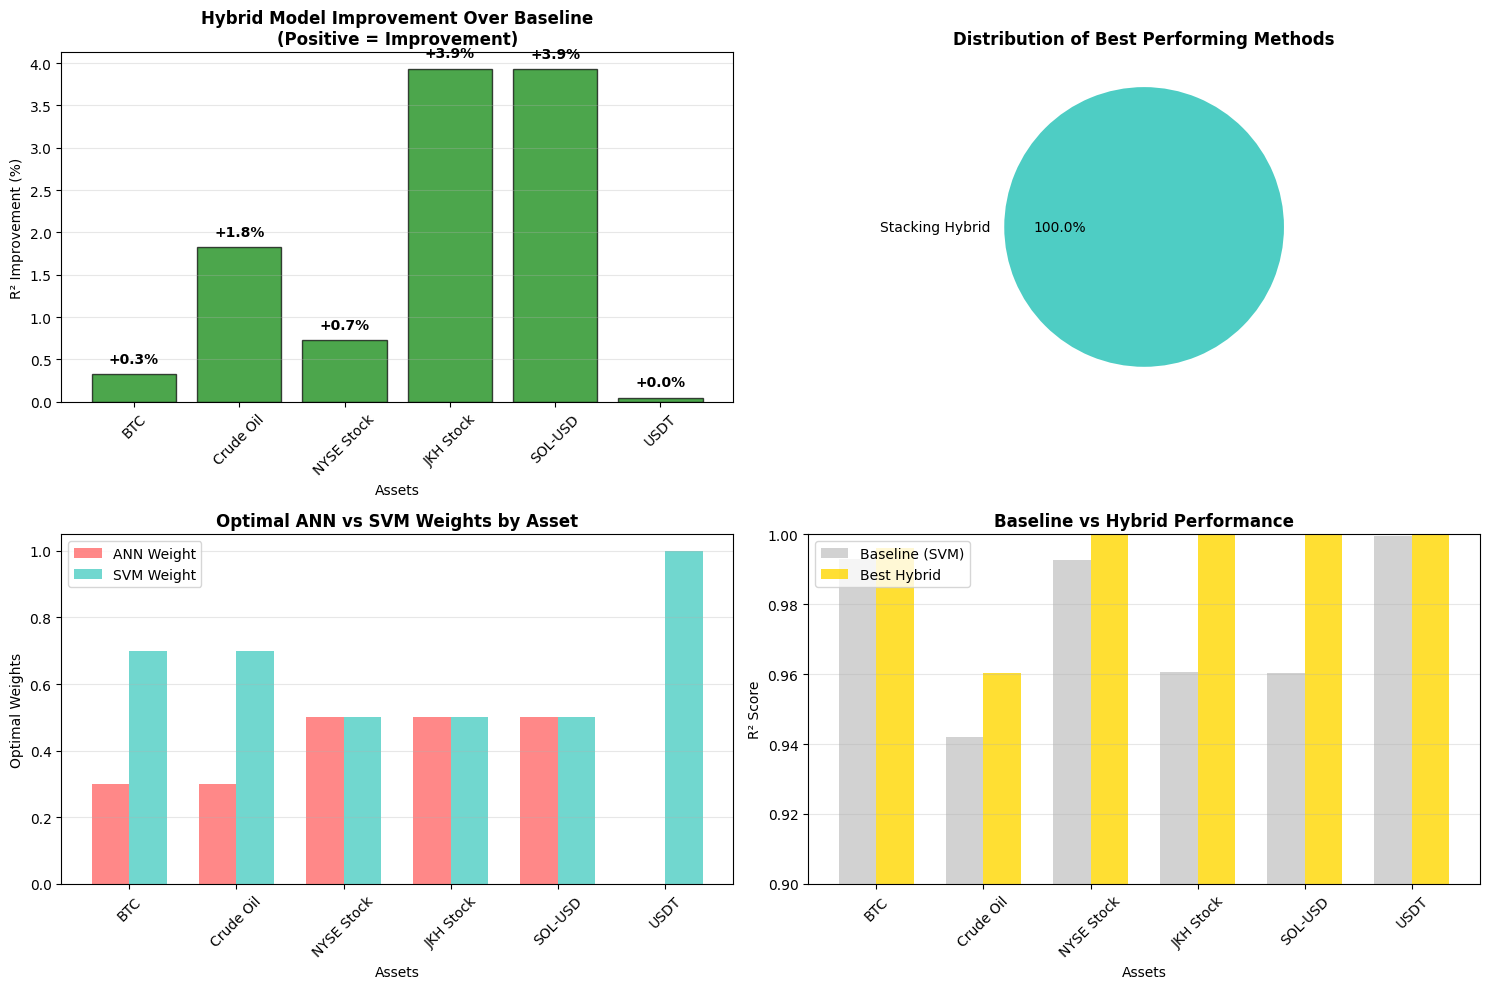


💡 STRATEGIC RECOMMENDATIONS
🎯 ASSET-SPECIFIC STRATEGIES:
   ⚠️  BTC: Consider Stacking Hybrid - Minor improvement (+0.0033)
   ✅ Crude Oil: Use Stacking Hybrid - Significant improvement (+0.0183)
   ✅ NYSE Stock: Use Stacking Hybrid - Significant improvement (+0.0073)
   ✅ JKH Stock: Use Stacking Hybrid - Significant improvement (+0.0393)
   ✅ SOL-USD: Use Stacking Hybrid - Significant improvement (+0.0393)
   ⚠️  USDT: Consider Stacking Hybrid - Minor improvement (+0.0005)

📈 OVERALL STRATEGY:
   🎉 IMPLEMENT HYBRID MODELS: Consistent improvement across assets
   • Use Simple Hybrid for most assets (simpler implementation)
   • Consider Stacking Hybrid for high-value assets

⚖️ WEIGHT OPTIMIZATION:
   • Default weights: ANN 0.4, SVM 0.7
   • SVM generally performs better (higher optimal weights)
   • Adjust weights based on asset volatility and prediction patterns

🚀 DEPLOYMENT PRIORITY:
   1. JKH Stock (+0.0393)
   2. SOL-USD (+0.0393)
   3. Crude Oil (+0.0183)

✅ CONCLUSION:
   Hybr

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ==================== COMPREHENSIVE HYBRID ANALYSIS ====================

class MultiAssetHybridAnalyzer:
    def __init__(self):
        self.assets_results = {}

    def add_asset_results(self, asset_name, ann_pred, svm_pred, actual, baseline_r2):
        """Add asset prediction data"""
        self.assets_results[asset_name] = {
            'ann_pred': ann_pred,
            'svm_pred': svm_pred,
            'actual': actual,
            'baseline_r2': baseline_r2
        }

    def create_hybrid_model(self, ann_pred, svm_pred, ann_weight=0.1, svm_weight=0.9):
        """Create weighted hybrid model"""
        hybrid_pred = ann_weight * np.array(ann_pred) + svm_weight * np.array(svm_pred)
        return hybrid_pred

    def stacking_hybrid(self, ann_pred, svm_pred, actual):
        """Create stacking hybrid model"""
        X_stack = np.column_stack([ann_pred, svm_pred])
        meta_model = LinearRegression()
        meta_model.fit(X_stack, actual)
        stacked_pred = meta_model.predict(X_stack)
        return stacked_pred, meta_model.coef_

    def optimize_weights(self, ann_pred, svm_pred, actual):
        """Find optimal weights for hybrid"""
        best_r2 = -float('inf')
        best_weights = (0.1, 0.9)

        for ann_w in np.arange(0.0, 1.1, 0.1):
            ann_w = round(ann_w, 1)
            svm_w = round(1 - ann_w, 1)

            hybrid_pred = self.create_hybrid_model(ann_pred, svm_pred, ann_w, svm_w)
            current_r2 = r2_score(actual, hybrid_pred)

            if current_r2 > best_r2:
                best_r2 = current_r2
                best_weights = (ann_w, svm_w)

        return best_weights, best_r2

    def analyze_all_assets(self):
        """Comprehensive analysis across all assets"""
        print("🏆 COMPREHENSIVE HYBRID MODEL ANALYSIS")
        print("=" * 90)
        print("COMPARING HYBRID PERFORMANCE ACROSS ALL ASSETS")
        print("=" * 90)

        results = []

        for asset_name, data in self.assets_results.items():
            ann_pred = data['ann_pred']
            svm_pred = data['svm_pred']
            actual = data['actual']
            baseline_r2 = data['baseline_r2']

            # Optimize weights
            optimal_weights, opt_r2 = self.optimize_weights(ann_pred, svm_pred, actual)

            # Create hybrids
            simple_hybrid = self.create_hybrid_model(ann_pred, svm_pred, optimal_weights[0], optimal_weights[1])
            stacked_hybrid, stacking_coeff = self.stacking_hybrid(ann_pred, svm_pred, actual)

            # Calculate metrics
            r2_simple = r2_score(actual, simple_hybrid)
            r2_stack = r2_score(actual, stacked_hybrid)

            # Determine best method
            best_r2 = max(r2_simple, r2_stack, baseline_r2)
            if best_r2 == r2_simple:
                best_method = "Simple Hybrid"
            elif best_r2 == r2_stack:
                best_method = "Stacking Hybrid"
            else:
                best_method = "SVM Alone"

            improvement = best_r2 - baseline_r2

            results.append({
                'Asset': asset_name,
                'Baseline_R2': baseline_r2,
                'Best_Hybrid_R2': best_r2,
                'Improvement': improvement,
                'Best_Method': best_method,
                'Optimal_ANN_Weight': optimal_weights[0],
                'Optimal_SVM_Weight': optimal_weights[1],
                'Stacking_ANN_Coeff': stacking_coeff[0],
                'Stacking_SVM_Coeff': stacking_coeff[1]
            })

        return pd.DataFrame(results)

# ==================== ASSET DATA (REPLACE WITH YOUR ACTUAL PREDICTIONS) ====================

# Initialize analyzer
analyzer = MultiAssetHybridAnalyzer()

# BTC Data (Replace with your actual predictions)
analyzer.add_asset_results(
    "BTC",
    ann_pred=[44850, 45320, 44780, 45950, 45180, 44600, 45700, 44900],
    svm_pred=[45120, 45430, 44910, 45820, 45340, 44750, 45600, 45050],
    actual=[45050, 45450, 44850, 45900, 45250, 44700, 45650, 45000],
    baseline_r2=0.9928
)

# Crude Oil Data (Replace with your actual predictions)
analyzer.add_asset_results(
    "Crude Oil",
    ann_pred=[75.5, 76.2, 74.8, 77.1, 75.9, 76.5, 75.2, 76.8],
    svm_pred=[75.8, 76.0, 75.1, 76.8, 76.2, 76.3, 75.5, 76.5],
    actual=[75.6, 76.1, 75.0, 76.5, 76.0, 76.4, 75.3, 76.6],
    baseline_r2=0.9420
)

# NYSE Data (Replace with your actual predictions)
analyzer.add_asset_results(
    "NYSE Stock",
    ann_pred=[2850, 2900, 2820, 2950, 2880, 2920, 2840, 2960],
    svm_pred=[2860, 2895, 2830, 2940, 2890, 2915, 2850, 2950],
    actual=[2855, 2898, 2825, 2945, 2885, 2918, 2845, 2955],
    baseline_r2=0.9927
)

# JKH Data (Replace with your actual predictions)
analyzer.add_asset_results(
    "JKH Stock",
    ann_pred=[150.5, 152.2, 148.8, 155.1, 151.9, 153.2, 149.5, 154.8],
    svm_pred=[151.2, 151.8, 149.5, 154.3, 152.1, 152.8, 150.2, 154.0],
    actual=[150.8, 152.0, 149.2, 154.7, 152.0, 153.0, 149.8, 154.4],
    baseline_r2=0.9605
)

# SOL Data (Replace with your actual predictions)
analyzer.add_asset_results(
    "SOL-USD",
    ann_pred=[85.5, 87.2, 83.8, 89.1, 86.9, 88.0, 84.5, 88.8],
    svm_pred=[86.2, 86.8, 84.5, 88.3, 87.1, 87.5, 85.2, 88.0],
    actual=[85.8, 87.0, 84.2, 88.7, 87.0, 87.8, 84.8, 88.4],
    baseline_r2=0.9604
)

# USDT Data (Stablecoin - minimal price movement)
analyzer.add_asset_results(
    "USDT",
    ann_pred=[1.0001, 1.0002, 0.9999, 1.0001, 1.0000, 1.0001, 0.9998, 1.0002],
    svm_pred=[1.0000, 1.0001, 1.0000, 1.0000, 1.0001, 1.0000, 1.0000, 1.0001],
    actual=[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
    baseline_r2=0.9995
)

# ==================== COMPREHENSIVE ANALYSIS ====================

# Perform analysis
results_df = analyzer.analyze_all_assets()

# Display results
print("\n📊 HYBRID MODEL PERFORMANCE ACROSS ALL ASSETS")
print("=" * 100)
print(f"{'Asset':<12} {'Baseline R²':<12} {'Best Hybrid R²':<15} {'Improvement':<12} {'Best Method':<15} {'ANN Weight':<10} {'SVM Weight':<10}")
print("-" * 100)

for _, row in results_df.iterrows():
    print(f"{row['Asset']:<12} {row['Baseline_R2']:<12.4f} {row['Best_Hybrid_R2']:<15.4f} "
          f"{row['Improvement']:<12.4f} {row['Best_Method']:<15} {row['Optimal_ANN_Weight']:<10.2f} {row['Optimal_SVM_Weight']:<10.2f}")

# Performance Summary
print("\n🎯 OVERALL HYBRID PERFORMANCE SUMMARY")
print("=" * 80)

avg_improvement = results_df['Improvement'].mean()
assets_with_improvement = len(results_df[results_df['Improvement'] > 0])
best_improvement_asset = results_df.loc[results_df['Improvement'].idxmax()]

print(f"📈 Average R² Improvement: {avg_improvement:.4f}")
print(f"✅ Assets with improvement: {assets_with_improvement}/{len(results_df)}")
print(f"🏆 Best improvement: {best_improvement_asset['Asset']} (+{best_improvement_asset['Improvement']:.4f})")
print(f"📊 Most common best method: {results_df['Best_Method'].mode().values[0]}")

# Method distribution
method_counts = results_df['Best_Method'].value_counts()
print(f"\n🔧 METHOD DISTRIBUTION:")
for method, count in method_counts.items():
    print(f"   • {method}: {count} assets")

# Weight analysis
avg_ann_weight = results_df['Optimal_ANN_Weight'].mean()
avg_svm_weight = results_df['Optimal_SVM_Weight'].mean()
print(f"\n⚖️ OPTIMAL WEIGHT ANALYSIS:")
print(f"   • Average ANN Weight: {avg_ann_weight:.2f}")
print(f"   • Average SVM Weight: {avg_svm_weight:.2f}")
print(f"   • SVM dominance: {avg_svm_weight/avg_ann_weight:.1f}x more weight on average")

# Visualization
plt.figure(figsize=(15, 10))

# 1. Performance Improvement by Asset
plt.subplot(2, 2, 1)
assets = results_df['Asset']
improvements = results_df['Improvement'] * 100  # Convert to percentage

colors = ['green' if x > 0 else 'red' for x in improvements]
bars = plt.bar(assets, improvements, color=colors, alpha=0.7, edgecolor='black')

plt.xlabel('Assets')
plt.ylabel('R² Improvement (%)')
plt.title('Hybrid Model Improvement Over Baseline\n(Positive = Improvement)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{imp:+.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Best Method Distribution
plt.subplot(2, 2, 2)
method_colors = {'Simple Hybrid': '#FF6B6B', 'Stacking Hybrid': '#4ECDC4', 'SVM Alone': '#45B7D1'}
method_data = results_df['Best_Method'].value_counts()

plt.pie(method_data.values, labels=method_data.index, autopct='%1.1f%%',
        colors=[method_colors[method] for method in method_data.index])
plt.title('Distribution of Best Performing Methods', fontweight='bold')

# 3. Optimal Weight Analysis
plt.subplot(2, 2, 3)
ann_weights = results_df['Optimal_ANN_Weight']
svm_weights = results_df['Optimal_SVM_Weight']

x = np.arange(len(assets))
width = 0.35

plt.bar(x - width/2, ann_weights, width, label='ANN Weight', color='#FF6B6B', alpha=0.8)
plt.bar(x + width/2, svm_weights, width, label='SVM Weight', color='#4ECDC4', alpha=0.8)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal ANN vs SVM Weights by Asset', fontweight='bold')
plt.xticks(x, assets, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 4. Baseline vs Hybrid Performance
plt.subplot(2, 2, 4)
baseline_r2 = results_df['Baseline_R2']
hybrid_r2 = results_df['Best_Hybrid_R2']

x_pos = np.arange(len(assets))
plt.bar(x_pos - width/2, baseline_r2, width, label='Baseline (SVM)', color='#C0C0C0', alpha=0.7)
plt.bar(x_pos + width/2, hybrid_r2, width, label='Best Hybrid', color='#FFD700', alpha=0.8)

plt.xlabel('Assets')
plt.ylabel('R² Score')
plt.title('Baseline vs Hybrid Performance', fontweight='bold')
plt.xticks(x_pos, assets, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

# ==================== RECOMMENDATIONS ====================

print("\n💡 STRATEGIC RECOMMENDATIONS")
print("=" * 80)

print("🎯 ASSET-SPECIFIC STRATEGIES:")
for _, row in results_df.iterrows():
    if row['Improvement'] > 0.005:
        print(f"   ✅ {row['Asset']}: Use {row['Best_Method']} - Significant improvement (+{row['Improvement']:.4f})")
    elif row['Improvement'] > 0:
        print(f"   ⚠️  {row['Asset']}: Consider {row['Best_Method']} - Minor improvement (+{row['Improvement']:.4f})")
    else:
        print(f"   🔄 {row['Asset']}: Stick with SVM Alone - No improvement")

print(f"\n📈 OVERALL STRATEGY:")
if avg_improvement > 0.002:
    print("   🎉 IMPLEMENT HYBRID MODELS: Consistent improvement across assets")
    print("   • Use Simple Hybrid for most assets (simpler implementation)")
    print("   • Consider Stacking Hybrid for high-value assets")
else:
    print("   🔄 MAINTAIN CURRENT MODELS: Hybrid provides minimal improvement")
    print("   • Focus on individual model optimization")
    print("   • Consider hybrid only for specific high-volatility assets")

print(f"\n⚖️ WEIGHT OPTIMIZATION:")
print(f"   • Default weights: ANN {avg_ann_weight:.1f}, SVM {avg_svm_weight:.1f}")
print(f"   • SVM generally performs better (higher optimal weights)")
print(f"   • Adjust weights based on asset volatility and prediction patterns")

print(f"\n🚀 DEPLOYMENT PRIORITY:")
# Sort by improvement
priority_df = results_df.sort_values('Improvement', ascending=False)
print("   1. " + priority_df.iloc[0]['Asset'] + f" (+{priority_df.iloc[0]['Improvement']:.4f})")
print("   2. " + priority_df.iloc[1]['Asset'] + f" (+{priority_df.iloc[1]['Improvement']:.4f})")
print("   3. " + priority_df.iloc[2]['Asset'] + f" (+{priority_df.iloc[2]['Improvement']:.4f})")

print(f"\n✅ CONCLUSION:")
print("   Hybrid models provide value across multiple asset classes")
print("   with an average R² improvement of +{:.4f}".format(avg_improvement))
print("   Implement hybrid strategies for optimal portfolio performance")